# Demonstration of normalization, registration, age group categorization

## Required libraries and functions

In [1]:
# required libraries
import nibabel as nib
import numpy as np
import os, subprocess
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from microfilm import microplot
import roifile
from skimage.draw import polygon2mask
from scipy.stats import norm

In [2]:
# set path to your greedy executable and vtk library
os.environ["PATH"] = "~/bin/greedy_build:" + os.environ.get("PATH","")
os.environ["LD_LIBRARY_PATH"] = "~/bin/vtk-lib:" + os.environ.get("LD_LIBRARY_PATH","")

In [3]:
# functions used in this demo

# for normalization demo
def normalize_vol(vol, percentile=99.99, clipping=True):
    lo = np.median(vol)
    hi = np.percentile(vol, percentile)
    norm = (vol - lo) / (hi - lo)
    if clipping:
        norm = np.where(norm < 0, 0, norm)
    return norm

def normalize_nii(path, percentile=99.99, clipping=True):
    from pathlib import Path
    path = Path(path)
    img = nib.load(path)
    data = img.get_fdata()
    norm_data = normalize_vol(data, percentile=percentile, clipping=clipping)
    norm = nib.Nifti1Image(norm_data, img.affine, img.header)
    nib.save(norm, path.parent / (f"norm_" + path.name))

def read_rotate_nii(path):
    im = nib.load(path)
    vol = im.get_fdata()
    vol = np.rot90(vol, k=-1, axes=(0,1))
    return vol

def rot90r(im):
    im = np.squeeze(im)
    assert im.ndim > 1 and im.ndim < 4
    if im.ndim == 3:
        out = np.rot90(im,k=-1, axes=(1,2))
    if im.ndim == 2:
        out = np.rot90(im,k=-1)
    return out


def zproj_panels(r_proj, ir_proj, sub_proj, title, limits, filepath=None):
    panel = microplot.Micropanel(rows=1, cols=3, margin = 0.4, figscaling=5)
    panel.fig.suptitle(f"Z projection: {title}")

    r_panel = microplot.Microimage(images=r_proj, cmaps=['gray'],
                                  label_text='JF585', label_location='lower left', channel_label_size=0.05,
                                  show_colorbar=True, limits = limits[0])
    panel.add_element(pos=[0,0], microim=r_panel)

    ir_panel = microplot.Microimage(images=ir_proj, cmaps=['gray'],
                                  label_text='JF635', label_location='lower left', channel_label_size=0.05,
                                  show_colorbar=True, limits = limits[1])
    panel.add_element(pos=[0,1], microim=ir_panel)

    sub_panel = microplot.Microimage(images=sub_proj, cmaps=['gray'],
                                  label_text='Subtracted', label_location='lower left', channel_label_size=0.05,
                                  show_colorbar=True, limits = limits[2])
    panel.add_element(pos=[0,2], microim=sub_panel)
    if filepath:
      panel.savefig(filepath)

def slice_panels(vol,zs, title,limits, filepath=None):
    nslice = len(zs)
    panel = microplot.Micropanel(rows=1, cols=nslice, margin = 0.4, figscaling=5)
    panel.fig.suptitle(f"Slice view: {title}")

    for i, z in enumerate(zs):
        cur = microplot.Microimage(
          images = vol[:,:,z],
          cmaps = "gray",
          limits=limits[i],
          label_text=f"z={z}",label_location='lower left',
          show_colorbar=True,)
        panel.add_element(pos=[0,i], microim=cur)

    if filepath:
        panel.savefig(filepath)

def subtract_split(i1,i2):
    pos = i1 - i2
    pos = np.where(pos< 0, 0, pos)
    neg = i2 - i1
    neg = np.where(neg< 0, 0, neg)
    return (pos, neg)


# for registration demo
def greedy_registration(
    ref_img,
    image_name,
    ref_channel,
    n_channels,
    gradient_sigma,
    warp_sigma,
    threads,
    greedy_path,
    affine_iterations,
    warp_iterations,
):
    """Execute a list of shell commands for image registration by Greedy.

    *The commands are explained in the attached txt file.

    *N.B. 'c2_warp.nii.gz' file and 'c2_affine.mat' file for the reference channel
    should have a different name from the output image for the 2nd channel.
    For instance, the 'f5_c2_warp.nii' file"""

    ref_channel_name = (
        f"{image_name}_c{ref_channel}"  # Append channel number to the file name
    )

    commands = [
        f"{greedy_path} -d 3 -threads {threads} -a -m WNCC 4x4x4 -i {ref_img} {ref_channel_name}.nii -o c{ref_channel}_affine.mat -ia-image-centers -n {affine_iterations}",
        f"{greedy_path} -d 3 -threads {threads} -a -m WNCC 4x4x4 -i {ref_img} {ref_channel_name}.nii -ia c{ref_channel}_affine.mat -o c{ref_channel}_affine.mat -n {affine_iterations}",
        f"{greedy_path} -d 3 -threads {threads} -rf {ref_img} -rm {ref_channel_name}.nii {ref_channel_name}_affine.nii -r c{ref_channel}_affine.mat -float",
        f"{greedy_path} -d 3 -threads {threads} -m WNCC 4x4x4 -i {ref_img} {ref_channel_name}.nii -it c{ref_channel}_affine.mat -o c{ref_channel}_warp.nii.gz -sv -n {warp_iterations} -s {gradient_sigma}vox {warp_sigma}vox",
    ]

    # Add commands for applying the affine and warp transformations calculated based on the reference channel to each channel of the input iamge
    for ch in range(1, n_channels + 1):
        channel_name = f"{image_name}_c{ch}"
        commands.append(
            f"{greedy_path} -d 3 -rf {ref_img} -rm {channel_name}.nii {channel_name}_warp.nii -r c{ref_channel}_warp.nii.gz c{ref_channel}_affine.mat -float"
        )

    with open("error.txt", "w") as error, open("output.txt", "w") as output:
        for cmd in commands:
            print(f"Running '{cmd}'")
            result = subprocess.run(
                cmd, shell=True, stdout=output, stderr=error, text=True
            )
            if result.returncode != 0:
                print(f"Error executing {cmd}: {result.stderr}\n")


# age categorization demo
def roi2mask(shape, roi):
    mask = polygon2mask(shape, np.flip(roi.coordinates(), axis=1))
    return mask


def roi_extract_pixels(im, roi):
    im = np.squeeze(im)
    mask = roi2mask(im.shape, roi)
    mask_indices = np.where(mask)
    pixels = im[mask_indices[0], mask_indices[1]]
    return pixels


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return (rho, phi)


def sigma_clipping(data, sigma=3, max_iter=10):
    filtered_data = data.copy()
    for _ in range(max_iter):
        mu, std = norm.fit(filtered_data)
        mask = (filtered_data > mu - sigma * std) & (filtered_data < mu + sigma * std)
        new_data = filtered_data[mask]
        if len(new_data) == len(filtered_data):  # Convergence
            break
        filtered_data = new_data
    return mu, std

## Effects of normalization

### Subtraction without normalization

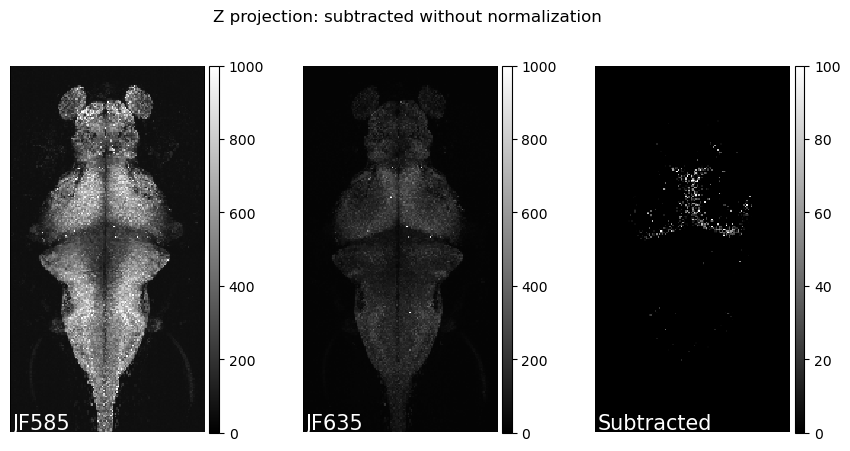

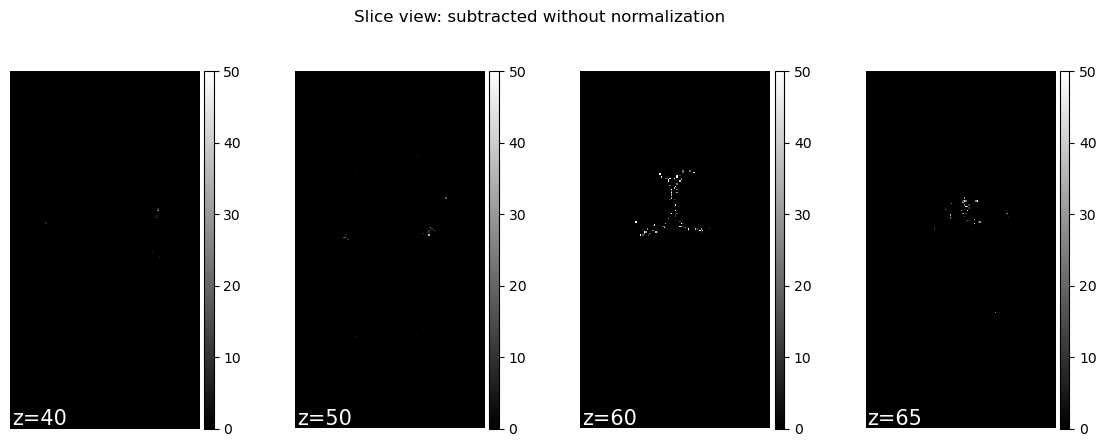

In [4]:
r_vol = read_rotate_nii('f1_c1.nii')
ir_vol = read_rotate_nii('f1_c2.nii')
pos, _ = subtract_split(ir_vol, r_vol)


title = f"subtracted without normalization"
proj_limits = [[0, 1000], [0, 1000], [0, 100]]
zproj_panels(r_vol.max(axis=2), ir_vol.max(axis=2), pos.max(axis=2), 
               title, proj_limits)

zs = [40, 50, 60, 65]
slice_limits = [[0, 50],[0, 50],[0, 50],[0, 50]]
slice_panels(pos, zs, title, slice_limits)

### Subtraction after normalizaiton using different percentiles

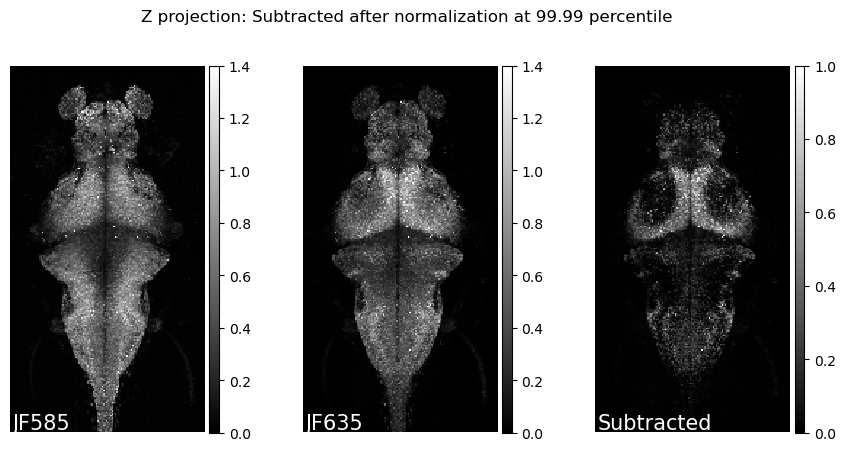

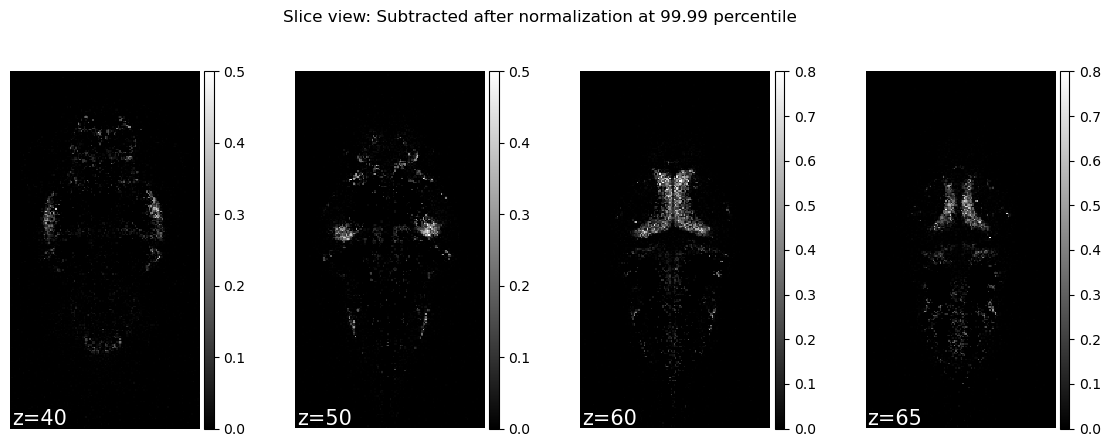

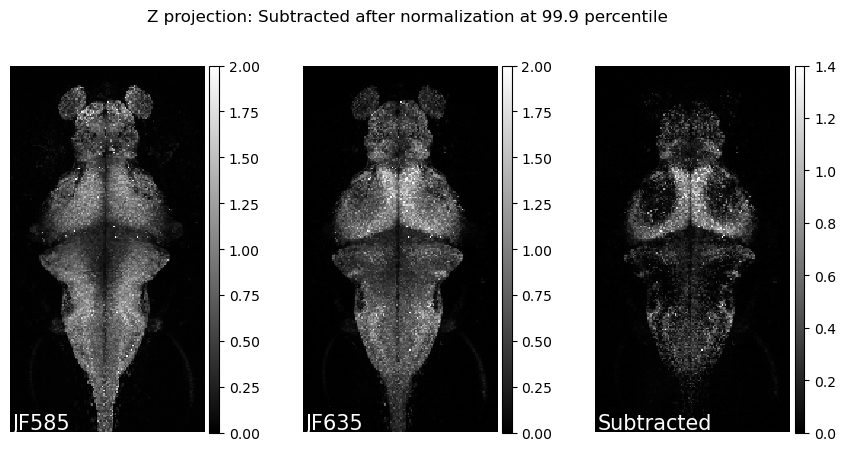

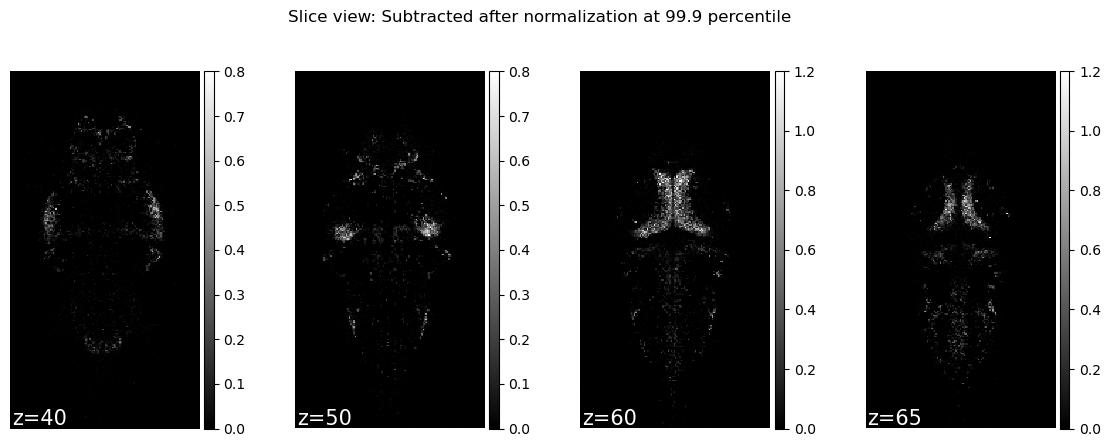

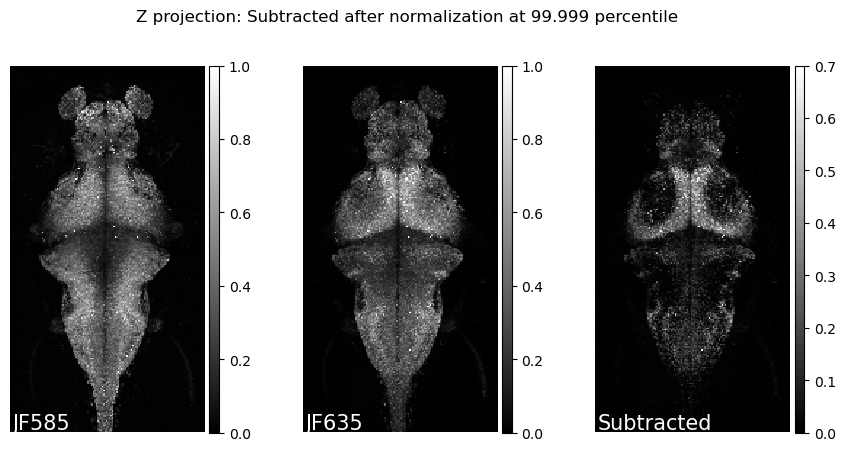

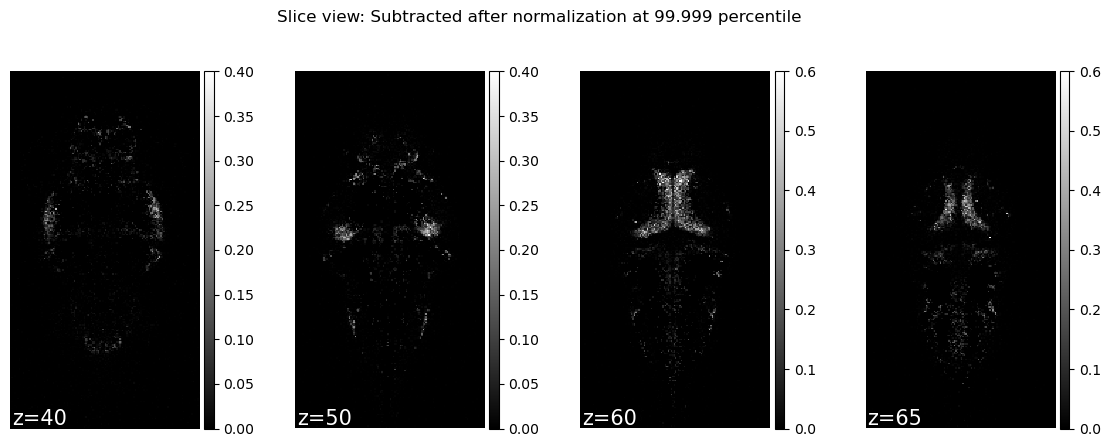

In [5]:
percentiles = [99.99, 99.9, 99.999]
proj_limits = [[[0, 1.4], [0, 1.4], [0, 1]], 
               [[0, 2.0], [0, 2.0], [0, 1.4]],
               [[0, 1.0], [0, 1.0], [0, 0.7]]]
slice_limits = [[[0, 0.5],[0, 0.5],[0, 0.8],[0, 0.8]],
                [[0, 0.8],[0, 0.8],[0, 1.2],[0, 1.2]],
                [[0, 0.4],[0, 0.4],[0, 0.6],[0, 0.6]]]

for i, percentile in enumerate(percentiles):
    norm_r_vol = normalize_vol(r_vol, percentile=percentile)
    norm_ir_vol = normalize_vol(ir_vol, percentile=percentile)
    pos, _ = subtract_split(norm_ir_vol, norm_r_vol)
    
    title = f"Subtracted after normalization at {percentile} percentile"
    zproj_panels(norm_r_vol.max(axis=2), norm_ir_vol.max(axis=2), pos.max(axis=2), 
                   title, proj_limits[i])
    
    zs = [40, 50, 60, 65]
    slice_panels(pos, zs, title, slice_limits[i])

## Registration

### Prepare normalized nii files

In [6]:
normalize_nii('f1_c1.nii')
normalize_nii('f1_c2.nii')
normalize_nii('f1_c3.nii')

### Run registration

In [7]:
greedy_registration(
    'huc-h2b-rfp-ref-01_ds.nii',
    'norm_f1',
    3,
    3,
    5.0,
    2.0,
    16,
    "greedy",
    "500x200x0x0",
    "200x200x200x200x0")

Running 'greedy -d 3 -threads 16 -a -m WNCC 4x4x4 -i huc-h2b-rfp-ref-01_ds.nii norm_f1_c3.nii -o c3_affine.mat -ia-image-centers -n 500x200x0x0'
Running 'greedy -d 3 -threads 16 -a -m WNCC 4x4x4 -i huc-h2b-rfp-ref-01_ds.nii norm_f1_c3.nii -ia c3_affine.mat -o c3_affine.mat -n 500x200x0x0'
Running 'greedy -d 3 -threads 16 -rf huc-h2b-rfp-ref-01_ds.nii -rm norm_f1_c3.nii norm_f1_c3_affine.nii -r c3_affine.mat -float'
Running 'greedy -d 3 -threads 16 -m WNCC 4x4x4 -i huc-h2b-rfp-ref-01_ds.nii norm_f1_c3.nii -it c3_affine.mat -o c3_warp.nii.gz -sv -n 200x200x200x200x0 -s 5.0vox 2.0vox'
Running 'greedy -d 3 -rf huc-h2b-rfp-ref-01_ds.nii -rm norm_f1_c1.nii norm_f1_c1_warp.nii -r c3_warp.nii.gz c3_affine.mat -float'
Running 'greedy -d 3 -rf huc-h2b-rfp-ref-01_ds.nii -rm norm_f1_c2.nii norm_f1_c2_warp.nii -r c3_warp.nii.gz c3_affine.mat -float'
Running 'greedy -d 3 -rf huc-h2b-rfp-ref-01_ds.nii -rm norm_f1_c3.nii norm_f1_c3_warp.nii -r c3_warp.nii.gz c3_affine.mat -float'


### Examine quality of registration

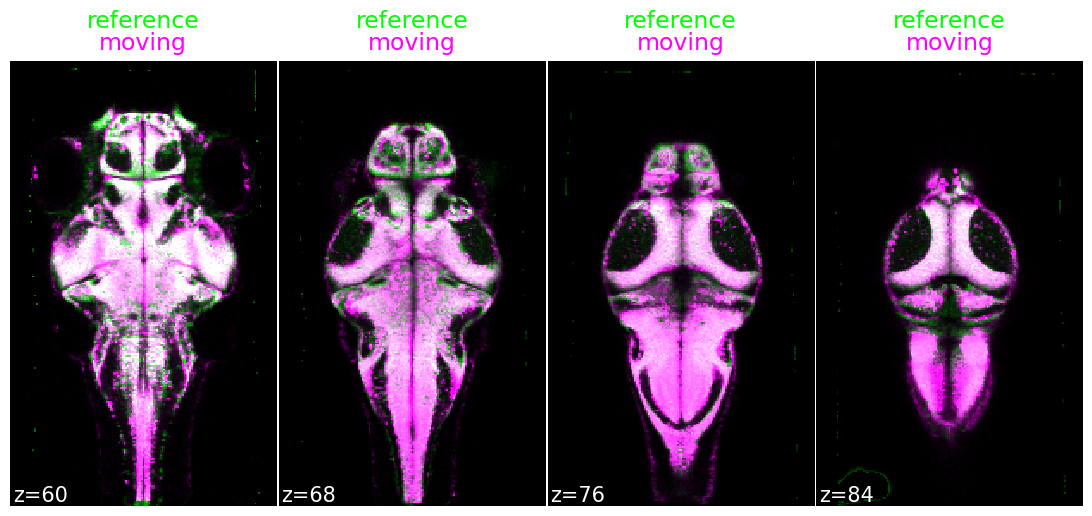

In [8]:
ref_vol = normalize_vol(read_rotate_nii('huc-h2b-rfp-ref-01_ds.nii'))
moving_vol = read_rotate_nii('norm_f1_c3_warp.nii')
channel_names = ['reference', 'moving']
merged = np.stack((ref_vol,moving_vol),axis=0)
micropanel = microplot.Micropanel(rows=1, cols=4, figscaling=5)
zs = [60, 68, 76, 84]
limits =[[[0, .5],[0, .1]], [[0, .8],[0, .2]],[[0, 1],[0, .2]],[[0, 1],[0, .2]]]

for i, z in enumerate(zs):
    im = microplot.Microimage(
        images = merged[:,:,:,zs[i]],
        cmaps = ["pure_green", "pure_magenta"],
        limits= limits[i],
        channel_label_show=True,
        channel_names=channel_names,
        label_text=f"z={z}",label_location='lower left')
    micropanel.add_element(pos=[0,i], microim=im)
    
micropanel.add_channel_label(channel_label_size=0.04)

### Subtration volume after registration

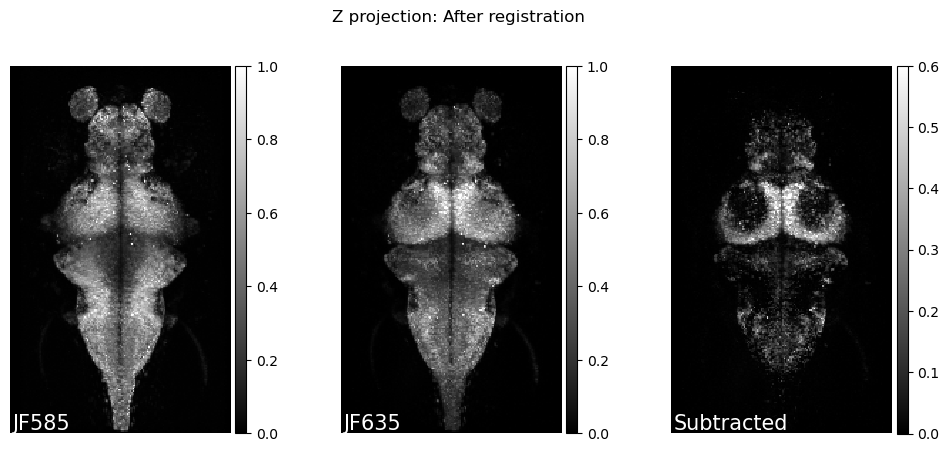

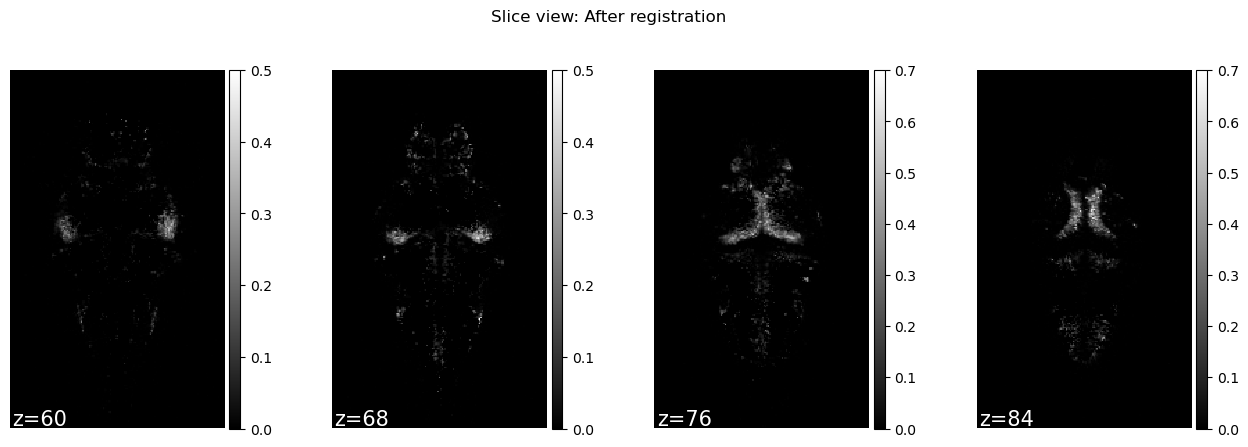

In [9]:
reg_r_vol = read_rotate_nii('norm_f1_c1_warp.nii')
reg_ir_vol = read_rotate_nii('norm_f1_c2_warp.nii')
reg_sub_vol = reg_ir_vol - reg_r_vol
reg_sub_vol = np.where(reg_sub_vol < 0, 0, reg_sub_vol)

title = f"After registration"
proj_limits = [[0, 1.0], [0, 1.0], [0, 0.6]]
zproj_panels(reg_r_vol.max(axis=2), reg_ir_vol.max(axis=2), reg_sub_vol.max(axis=2), 
               title, proj_limits)

zs = [60, 68, 76, 84]
slice_limits = [[0, 0.5],[0, 0.5],[0, 0.7],[0, 0.7]]
slice_panels(reg_sub_vol, zs, title, slice_limits)

## Age group categorization

### Example image

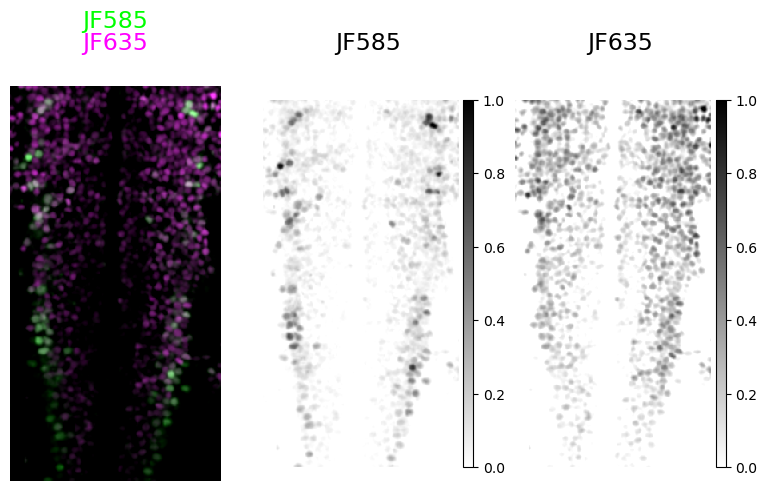

In [10]:
im = imread('r_fr_example.tif')
r_im = normalize_vol(im[0,:,:])
ir_im = normalize_vol(im[1,:,:])
ndim = r_im.shape
ch_names= ["JF585", "JF635"]

merged = np.stack((r_im, ir_im), axis=0)
pos, neg = subtract_split(ir_im, r_im)

orig = microplot.Micropanel(rows=1, cols=3, margin=0.2,figscaling=5)
mer = microplot.Microimage(
    images = rot90r(merged),
    cmaps = ["pure_green", "pure_magenta"],
    limits=[[0, 1],[0, 1]],
    channel_label_show=True,
    channel_names=ch_names)
orig.add_element(pos=[0,0], microim=mer)

r = microplot.Microimage(
    images = rot90r(r_im),
    cmaps = ["gray_r"],
    limits=[0, 1],
    show_colorbar=True,
    channel_label_show=True,
    channel_names=ch_names[0])
orig.add_element(pos=[0,1], microim=r)

ir = microplot.Microimage(
    images = rot90r(ir_im),
    cmaps = ["gray_r"],
    limits=[0, 1],
    show_colorbar=True,
    channel_label_show=True,
    channel_names=ch_names[1])
orig.add_element(pos=[0,2], microim=ir)

orig.add_channel_label(channel_label_size=0.04)

### Categorizing age group

Threshold: 0.7880266880439997


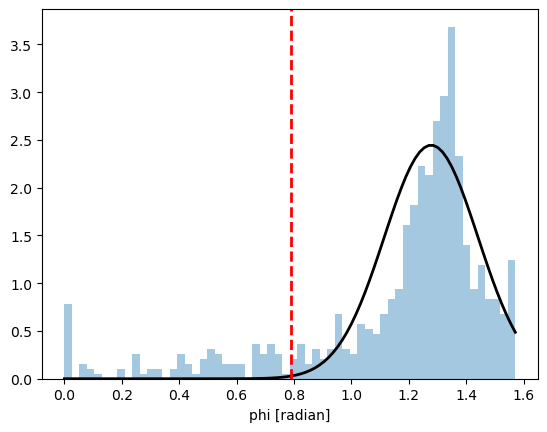

In [11]:
rois = roifile.roiread('rois_example.zip')

n_rois = len(rois)
r_sig = np.zeros((n_rois,))
ir_sig = np.zeros((n_rois,))
for i, roi in enumerate(rois):
    r_sig[i] = np.mean(roi_extract_pixels(r_im, roi))
    ir_sig[i] = np.mean(roi_extract_pixels(ir_im, roi))

# determine the angle
rho, phi = cart2pol(r_sig, ir_sig)

plt.figure()
plt.hist(phi, bins=60, alpha=0.4, density=True)

# Gasussian Mixture Model also works but sigma clipping works more reliably when one channel is more dominant
mu, std = sigma_clipping(phi)

x = np.linspace(phi.min(), phi.max(), 100)
pdf = norm.pdf(x, mu, std)
plt.plot(x, pdf, 'k', linewidth=2, label=f'Gaussian Fit\nMean={mu:.2f}, StdDev={std:.2f}')
plt.xlabel('phi [radian]')
phi_threshold = mu - 3*std
print(f"Threshold: {phi_threshold}")
plt.axvline(x=phi_threshold, color='r', linestyle='--', linewidth=2)

### Determined age groups 

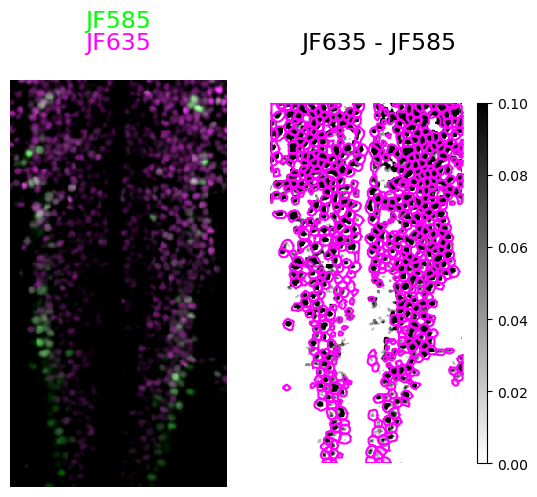

In [12]:
cat = microplot.Micropanel(rows=1, cols=2,margin = 0.2, figscaling=5)

m_im = microplot.Microimage(
    images = rot90r(merged),
    cmaps = ["pure_green", "pure_magenta"],
    limits=[[0, 1],[0, 1]],
    channel_label_show=True,
    channel_names=ch_names)

cat.add_element(pos=[0,0], microim=m_im)

p_im = microplot.Microimage(
    images = rot90r(pos),
    cmaps = "gray_r",
    limits=[0, .1],
    show_colorbar=True,
    channel_label_show=True,
    channel_names=f"{ch_names[1]} - {ch_names[0]}")

cat.add_element(pos=[0,1], microim=p_im)

cat.add_channel_label(channel_label_size=0.04)

p_ax = cat.ax[0,1]
for i, roi in enumerate(rois):
    coords = roi.coordinates()
    if phi[i] > phi_threshold:
        color='magenta'
        p_ax.plot(ndim[0]-coords[:,1], coords[:,0],color=color)


